In [ ]:
# Training 25 vindr models 
import pandas as pd 
import os 
import numpy as np
import subprocess

# File paths and setup
parent = '/home/jkim/research/peds_cxr/'
# Predefined 25 random seeds
predefined_seeds = [9,17,18,29,30,34,41,42,51,52,61,66,74,75,78,81,84,86,87,89,90,92,96,98,99]

### set source
metadata_source = parent + '25variation/metadata/final/vindr/' 

for seed in predefined_seeds:
    image_source = parent + '25variation/images/vindr/vindr_' + str(seed)
    # Load the data from the CSV file into a pandas DataFrame
    vindr_metadata_path = metadata_source + f'/vindr_metadata_seed_{seed}.csv'
    vindr_metadata = pd.read_csv(vindr_metadata_path)

    # Creating image_paths.txt
    image_path = vindr_metadata['Image Index']
    output_image_txt = image_source + '/image_paths.txt'
    image_path.to_csv(output_image_txt, sep=',', index=False, header=False)

    # Creating train.txt 
    train_index = vindr_metadata[vindr_metadata['Set']=='train']
    vindr_train_output = image_source + '/train.txt'
    vindr_train_txt = train_index['Image Index'] 
    vindr_train_txt.to_csv(vindr_train_output, sep=',', index=False, header=False)

    # Creating val.txt 
    val_index = vindr_metadata[vindr_metadata['Set']=='val']
    vindr_val_output = image_source + '/val.txt'
    vindr_val_txt = val_index['Image Index'] 
    vindr_val_txt.to_csv(vindr_val_output, sep=',', index=False, header=False)

    # Creating test.txt
    test_index = vindr_metadata[vindr_metadata['Set']=='test']
    vindr_test_output = image_source + '/vindr_test.txt'
    vindr_test_txt = test_index['Image Index'] 
    vindr_test_txt.to_csv(vindr_test_output, sep=',', index=False, header=False)

    # Creating labels.csv
    vindr_labels_output = image_source + '/labels.csv'
    vindr_labels = vindr_metadata[['Image Index', 'No Finding', 'Cardiomegaly', 'Consolidation', 'Infiltration', 'Mass/Nodule', 'Pneumonia']]
    # rename Image Index to Image
    vindr_labels = vindr_labels.rename(columns={'Image Index': 'Image'})
    vindr_labels.to_csv(vindr_labels_output, sep=',', index=False)

    # confirming the number of train val and test. 
    print("# of train:",len(vindr_train_txt))
    print('# of val:',len(vindr_val_txt))
    print('# of test:',len(vindr_test_txt))
    print('# of image path:',len(image_path))
    print('# of labels:',len(vindr_labels))


In [ ]:
# Create json file. 
import json
import os

# Base JSON content template
json_template = {
    "data_dir": "/home/jkim/research/peds_cxr/25variation/images/vindr/",
    "labels": ["No Finding", "Cardiomegaly", "Consolidation", "Infiltration", "Mass/Nodule", "Pneumonia"],
    "dataset_nicenames": {
        "vindrcxr14_test": "vindr CXR14",
        "chexpert_test": "CheXpert",
        "mimic_test": "MIMIC",
        "padchest_test": "PadChest",
        "rsna_pneumonia_test_100": "RSNA Pneumonia",
        "rsna_pneumonia_DeiT-B_test_100": "RSNA Pneumonia DeiT-B",
        "vindr_DenseNet121_vindr_test": "VinDR DenseNet121",
    }
}

# Loop through each seed to generate JSON files
for seed in predefined_seeds:
    # Construct the new directory path
    new_data_dir = f"/home/jkim/research/peds_cxr/25variation/images/vindr/vindr_{seed}/"
    
    # Create the new directory if it doesn't exist
    if not os.path.exists(new_data_dir):
        print(f"The directory {new_data_dir} does not exist. Creating it.")
        os.makedirs(new_data_dir)

    # Specify the path for the new JSON file
    new_json_path = os.path.join(new_data_dir, f"cfg_vindr_{seed}.json")

    # Write the JSON file
    with open(new_json_path, 'w') as f:
        json.dump(json_template, f, indent=4)
    
    print(f"Created new JSON file at {new_json_path}")

# batch creating result directiory
for seed in predefined_seeds:
    # Construct the new directory path for results
    new_result_dir = f"/home/jkim/research/peds_cxr/25variation/results/vindr/train/vindr_{seed}/"
    
    # Create the new directory if it doesn't exist
    if not os.path.exists(new_result_dir):
        os.makedirs(new_result_dir)

In [ ]:
# Define a list of hyperparameters to test
optimizers = ['SGD','AdamW'] 
initial_lrs = [5e-3, 1e-2, 5e-2, 1e-1]
weight_decays = [0, 1e-5, 1e-4, 1e-3]
dropouts = [0, 0.5]
gpu='2' 

# Iterate over the hyperparameters
for seed in ['42']:    
    for optimizer in optimizers:
        for initial_lr in initial_lrs:
            for weight_decay in weight_decays:
                for dropout in dropouts:
                    # Construct the command with updated hyperparameters
                    command = [
                        'python3',
                        parent + 'transformer-radiographs/train_cxr.py',
                        '--cfg-dir',
                        parent + f'25variation/images/vindr/vindr_{seed}/cfg_vindr_{seed}.json',
                        '--dataset',
                        f'vindr_{seed}',
                        '--labels-set',
                        'labels',
                        '--architecture',
                        'DenseNet121',
                        '--results-dir',
                        parent + '25variation/results/vindr/train/vindr_' + str(seed),
                        '--optimizer-family',
                        optimizer,
                        '--dropout',
                        str(dropout),
                        '--weight-decay',
                        str(weight_decay),
                        '--initial-lr',
                        str(initial_lr),
                        '--drop-factor',
                        '0.1',
                        '--plateau-patience',
                        '3',
                        '--plateau-threshold',
                        '1e-4',
                        '--break-patience',
                        '5',
                        '--train-transform',
                        'peds',
                        '--train-file',
                        'train.txt',
                        '--val-file',
                        'val.txt',
                        '--use-gpus',
                        gpu
                    ]

                    # Execute the command
                    subprocess.run(command)

In [ ]:
#training 25 vindr models DenseNet121_lr0.01_bs16_optSGD_wd0.0_sch_step_pp3_bp5_trtrain.txt_vaval.txt_tfpeds_nlbatch_do0.0_1708399128.txt
optimizers = ['SGD']
initial_lrs = [0.01]
weight_decays = [0]
dropouts = [0]
gpu='0' 

# Iterate over the hyperparameters
for seed in predefined_seeds:    
    for optimizer in optimizers:
        for initial_lr in initial_lrs:
            for weight_decay in weight_decays:
                for dropout in dropouts:
                    # Construct the command with updated hyperparameters
                    command = [
                        'python3',
                        parent + 'transformer-radiographs/train_cxr.py',
                        '--cfg-dir',
                        parent + f'25variation/images/vindr/vindr_{seed}/cfg_vindr_{seed}.json',
                        '--dataset',
                        f'vindr_{seed}',
                        '--labels-set',
                        'labels',
                        '--architecture',
                        'DenseNet121',
                        '--results-dir',
                        parent + '25variation/results/vindr/train/vindr_' + str(seed),
                        '--optimizer-family',
                        optimizer,
                        '--dropout',
                        str(dropout),
                        '--weight-decay',
                        str(weight_decay),
                        '--initial-lr',
                        str(initial_lr),
                        '--drop-factor',
                        '0.1',
                        '--plateau-patience',
                        '3',
                        '--plateau-threshold',
                        '1e-4',
                        '--break-patience',
                        '5',
                        '--train-transform',
                        'peds',
                        '--train-file',
                        'train.txt',
                        '--val-file',
                        'val.txt',
                        '--use-gpus',
                        gpu
                    ]

                    # Execute the command
                    subprocess.run(command)

In [11]:
#training 25 vindr models DenseNet121_lr0.01_bs16_optSGD_wd0.0_sch_step_pp3_bp5_trtrain.txt_vaval.txt_tfpeds_nlbatch_do0.0_1708399128.txt

# testing 25 vindr models
import subprocess
import pandas as pd 
import os
import glob

# batch creating result directiory
for seed in predefined_seeds:
    for dir in ['all', 'M', 'F']:
        # Construct the new directory path for results
        new_result_dir = parent + f"25variation/results/vindr/test/{dir}/vindr_{seed}_{dir}/"
        
        # Create the new directory if it doesn't exist
        if not os.path.exists(new_result_dir):
            os.makedirs(new_result_dir)

for seed in predefined_seeds:
    vindr_metadata_path = parent + '25variation/metadata/final/vindr/vindr_metadata_seed_' + str(seed) + '.csv'
    vindr_metadata = pd.read_csv(vindr_metadata_path)

    # Creating vindr_test_male / female .txt
    sexs = ['M', 'F']
    for sex in sexs:
        test_index = vindr_metadata[(vindr_metadata['Set'] == 'test') & (vindr_metadata['Patient Gender'] == sex)]
        image_source = parent + '25variation/images/vindr/vindr_' + str(seed) + '/'
        vindr_test_output = image_source + 'vindr_test_'+ sex +'.txt'
        vindr_test_txt = test_index['Image Index']
        vindr_test_txt.to_csv(vindr_test_output, sep=',', index=False, header=False)
    
for seed in predefined_seeds:
    # Build the pattern to search for model files
    search_pattern = os.path.join(parent, f"25variation/results/vindr/train/vindr_{seed}/DenseNet121_lr0.01_bs16_optSGD_wd0.0_sch_step_pp3_bp5_trtrain.txt_vaval.txt_tfpeds_nlbatch_do0.0_*_model.pt")
    
    # Use glob to find the file
    matching_files = glob.glob(search_pattern)
    
    # Check if any matching files are found
    if not matching_files:
        print(f"No matching model files found for seed {seed}.")
        continue  # Skip to the next iteration

    # Take the first matching file
    model_file_path = matching_files[0]

    image_source = parent + f'25variation/images/vindr/vindr_{seed}/'
    command = [
        "python3",
        parent + "transformer-radiographs/test_cxr.py",
        "--cfg-dir", parent + f"25variation/images/vindr/vindr_{seed}/cfg_vindr_{seed}.json",
        "--dataset", f'vindr_{seed}',
        "--labels-set", "labels",
        "--model-state", model_file_path,
        "--model-type", "DenseNet121",
        "--results-dir", parent + f"25variation/results/vindr/test/all/vindr_{seed}_all",
        "--test-file", image_source + "vindr_test.txt",
        "--use-gpus", gpu
    ]

    # Run the command
    try:
        subprocess.run(command, check=True)
    except subprocess.CalledProcessError as e:
        print(f"An error occurred while executing the command: {e}")




Test set: starting load
Using image path file
Using no transforms
Loaded 1635 images
Device: cuda #: 1 #cpus: 128

dict_keys(['vindr_9_DenseNet121_vindr_test'])

Test set: starting load
Using image path file
Using no transforms
Loaded 1635 images
Device: cuda #: 1 #cpus: 128

dict_keys(['vindr_17_DenseNet121_vindr_test'])

Test set: starting load
Using image path file
Using no transforms
Loaded 1635 images
Device: cuda #: 1 #cpus: 128

dict_keys(['vindr_18_DenseNet121_vindr_test'])

Test set: starting load
Using image path file
Using no transforms
Loaded 1635 images
Device: cuda #: 1 #cpus: 128

dict_keys(['vindr_29_DenseNet121_vindr_test'])

Test set: starting load
Using image path file
Using no transforms
Loaded 1635 images
Device: cuda #: 1 #cpus: 128

dict_keys(['vindr_30_DenseNet121_vindr_test'])

Test set: starting load
Using image path file
Using no transforms
Loaded 1635 images
Device: cuda #: 1 #cpus: 128

dict_keys(['vindr_34_DenseNet121_vindr_test'])

Test set: starting loa

In [12]:
#training 25 vindr models DenseNet121_lr0.01_bs16_optSGD_wd0.0_sch_step_pp3_bp5_trtrain.txt_vaval.txt_tfpeds_nlbatch_do0.0

# Testing M vs F
for sex in sexs:
    for seed in predefined_seeds:
    # Build the pattern to search for model files
        search_pattern = os.path.join(parent, f"25variation/results/vindr/train/vindr_{seed}/DenseNet121_lr0.01_bs16_optSGD_wd0.0_sch_step_pp3_bp5_trtrain.txt_vaval.txt_tfpeds_nlbatch_do0.0_*_model.pt")
        
        # Use glob to find the file
        matching_files = glob.glob(search_pattern)
        
        # Check if any matching files are found
        if not matching_files:
            print(f"No matching model files found for seed {seed}.")
            continue  # Skip to the next iteration

        # Assuming there's only one matching file, take the first one
        model_file_path = matching_files[0]

        image_source = parent + f'25variation/images/vindr/vindr_{seed}/' 
        command = [
            "python3",
            parent + "transformer-radiographs/test_cxr.py",
            "--cfg-dir", parent + f"25variation/images/vindr/vindr_{seed}/cfg_vindr_{seed}.json",
            "--dataset", f'vindr_{seed}',
            "--labels-set", "labels",
            "--model-state", model_file_path,
            "--model-type", "DenseNet121",
            "--results-dir", parent + f"25variation/results/vindr/test/{sex}/vindr_{seed}_{sex}",
            "--test-file", image_source + "vindr_test_" + sex + ".txt",
            "--use-gpus", gpu
    ]

        # Run the command
        try:
            subprocess.run(command, check=True)
        except subprocess.CalledProcessError as e:
            print(f"An error occurred while executing the command: {e}")


Test set: starting load
Using image path file
Using no transforms
Loaded 919 images
Device: cuda #: 1 #cpus: 128

dict_keys(['vindr_9_DenseNet121_vindr_test_M'])

Test set: starting load
Using image path file
Using no transforms
Loaded 919 images
Device: cuda #: 1 #cpus: 128

dict_keys(['vindr_17_DenseNet121_vindr_test_M'])

Test set: starting load
Using image path file
Using no transforms
Loaded 919 images
Device: cuda #: 1 #cpus: 128

dict_keys(['vindr_18_DenseNet121_vindr_test_M'])

Test set: starting load
Using image path file
Using no transforms
Loaded 919 images
Device: cuda #: 1 #cpus: 128

dict_keys(['vindr_29_DenseNet121_vindr_test_M'])

Test set: starting load
Using image path file
Using no transforms
Loaded 919 images
Device: cuda #: 1 #cpus: 128

dict_keys(['vindr_30_DenseNet121_vindr_test_M'])

Test set: starting load
Using image path file
Using no transforms
Loaded 919 images
Device: cuda #: 1 #cpus: 128

dict_keys(['vindr_34_DenseNet121_vindr_test_M'])

Test set: starti

In [13]:
import pickle
import pandas as pd
import os 
import glob

sexs = ['all','M','F']
sex_file_name = ['', '_M', '_F']
for sex, sex_name in zip(sexs, sex_file_name):
    for seed in predefined_seeds:
        # Build the pattern to search for model files
            search_pattern = os.path.join(parent, f"25variation/results/vindr/test/{sex}/vindr_{seed}_{sex}/DenseNet121_lr0.01_bs16_optSGD_wd0.0_sch_step_pp3_bp5_trtrain.txt_vaval.txt_tfpeds_nlbatch_do0.0_*.pkl")
        
            # Use glob to find the file
            matching_files = glob.glob(search_pattern)
            
            # Check if any matching files are found
            if not matching_files:
                print(f"No matching model files found for seed {seed}.")
                continue  # Skip to the next iteration

            pkl_directory = matching_files[0]

            directory = parent + f'25variation/results/vindr/unpickle/{sex}/'
            if not os.path.exists(directory):
                os.makedirs(directory)

            # Open the pickle file and load the data
            with open(pkl_directory, "rb") as f:
                data = pickle.load(f)

            # Extract the nested dictionary
            nested_dict = data.get(f'vindr_{seed}_DenseNet121_vindr_test{sex_name}', {})

            # Create a DataFrame from the nested dictionary with keys 'y', 'yhat', and 'file'
            df_nested = pd.DataFrame({
                "y": nested_dict["y"],
                "yhat": nested_dict["yhat"],
                "file": nested_dict["file"]
            })

            # Define the file path
            nested_file_path = directory + f'vindr_{seed}_{sex}_pkl.csv'

            # Save the DataFrame to a CSV file
            df_nested.to_csv(nested_file_path, index=False)


In [14]:
# Saving Pkl file as csv file 

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
import ast
import os
import matplotlib.pyplot as plt

parent = '/home/jkim/research/peds_cxr/'

# Changing pickle file from dictionary format to list format 
sexs = ['all', 'M', 'F']

# create AUC directory in results
if not os.path.exists(parent + '25variation/results/vindr/analysis/'):
    os.makedirs(parent + '25variation/results/vindr/analysis/')
if not os.path.exists(parent + '25variation/results/vindr/analysis/plot/all'):
    os.makedirs(parent + '25variation/results/vindr/analysis/plot/all')
if not os.path.exists(parent + '25variation/results/vindr/analysis/plot/MF'):
    os.makedirs(parent + '25variation/results/vindr/analysis/plot/MF')
if not os.path.exists(parent + '25variation/results/vindr/analysis/csv'):
    os.makedirs(parent + '25variation/results/vindr/analysis/csv')

for sex in sexs: 
    if not os.path.exists(parent + f'25variation/results/vindr/analysis/unpickledcsv/{sex}'):
        os.makedirs(parent + f'25variation/results/vindr/analysis/unpickledcsv/{sex}')  

for seed in predefined_seeds:        
    for sex in sexs: 
        # set directories
        pkl_dir = parent + f'25variation/results/vindr/unpickle/{sex}/vindr_{seed}_{sex}_pkl.csv'

        # Loading the pkl file
        vindr_pkl = pd.read_csv(pkl_dir)

        # Defining the vindr_label as the list of labels
        vindr_label = ["No Finding", "Cardiomegaly", "Consolidation", "Infiltration", "Mass/Nodule", "Pneumonia"]

        # Converting the string representation of lists to actual lists
        vindr_pkl['y'] = vindr_pkl['y'].apply(ast.literal_eval)
        vindr_pkl['yhat'] = vindr_pkl['yhat'].apply(ast.literal_eval)

        # Splitting the one-hot encoded labels and predictions into separate columns
        y_true_df = pd.DataFrame(vindr_pkl['y'].tolist(), columns=vindr_label)
        y_pred_df = pd.DataFrame(vindr_pkl['yhat'].tolist(), columns=vindr_label)

        # Merging the true labels and predicted probabilities based on index
        result_df = pd.concat([y_true_df, y_pred_df.add_suffix('_pred')], axis=1)

        # Saving
        result_df.to_csv(parent + f'25variation/results/vindr/analysis/unpickledcsv/{sex}/vindr_{seed}_{sex}_pkl.csv', index=False)


In [15]:
# stats and plotting for all vindr data 
import os
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, auc
from scipy.stats import sem


# Initialize variables
parent = '/home/jkim/research/peds_cxr/'
base_file_path = parent + "/25variation/results/vindr/analysis/unpickledcsv/all/"
labels = ["No Finding", "Cardiomegaly", "Consolidation", "Infiltration", "Mass/Nodule", "Pneumonia"]
all_metrics = {label: [] for label in labels}
all_metrics['All Label'] = []

# Initialize the dictionary to hold universal thresholds for each label
universal_thresholds = {label: {} for label in labels}

# Base file paths for male and female CSV files
base_file_path_M = parent + "25variation/results/vindr/analysis/unpickledcsv/M/vindr_{seed}_M_pkl.csv"
base_file_path_F = parent + "25variation/results/vindr/analysis/unpickledcsv/F/vindr_{seed}_F_pkl.csv"
base_file_path_all = parent + "25variation/results/vindr/analysis/unpickledcsv/all/vindr_{seed}_all_pkl.csv"

# Loop through all seeds
for seed in predefined_seeds:
    file_path = os.path.join(parent, f"25variation/results/vindr/analysis/unpickledcsv/all/vindr_{seed}_all_pkl.csv")
    df = pd.read_csv(file_path)
    
    for label in labels:
        true_labels = df[f'{label}']
        predicted_scores = df[f'{label}_pred']
        
        # Calculate ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(true_labels, predicted_scores)
                
        # Calculating Youden's Index to find the optimal threshold
        youden_index = tpr + (1 - fpr) - 1
        optimal_idx = np.argmax(youden_index)
        optimal_threshold = thresholds[optimal_idx]
        
        # Store this optimal threshold for this label and seed
        universal_thresholds[label][seed] = optimal_threshold

def calculate_metrics_and_auroc(df, label, optimal_threshold):
    true_labels = df[label]
    predicted_scores = df[f"{label}_pred"]
    
    # Calculate AUROC
    auroc = roc_auc_score(true_labels, predicted_scores)
    
    # Other metrics
    predicted_labels = (predicted_scores >= optimal_threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ppv = tp / (tp + fp) if tp + fp != 0 else 0
    npv = tn / (tn + fn) if tn + fn != 0 else 0
    f1_score = 2 * (ppv * sensitivity) / (ppv + sensitivity) if ppv + sensitivity != 0 else 0
    fpr = fp / (fp + tn)  
    fnr = fn / (fn + tp)
    
    return [auroc, sensitivity, specificity, ppv, npv, f1_score, fpr, fnr, optimal_threshold]

# Initialize empty DataFrames for storing metrics
cols = ['Seed', 'Label', 'AUROC', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'F1 Score', 'FPR', 'FNR', 'Youden_Threshold'] 
metrics_M_df = pd.DataFrame(columns=cols)
metrics_F_df = pd.DataFrame(columns=cols)
metrics_all_df = pd.DataFrame(columns=cols)

# Loop through all seeds
for seed in predefined_seeds:
    df_male = pd.read_csv(base_file_path_M.format(seed=seed))
    df_female = pd.read_csv(base_file_path_F.format(seed=seed))
    df_all = pd.read_csv(base_file_path_all.format(seed=seed))

    metrics_M_all_label = []
    metrics_F_all_label = []
    metrics_all_all_label = []

    for label in labels:
        optimal_threshold = universal_thresholds[label][seed]
        
        # Calculate metrics for male and female
        metrics_M = calculate_metrics_and_auroc(df_male, label, optimal_threshold)
        metrics_F = calculate_metrics_and_auroc(df_female, label, optimal_threshold)
        metrics_all = calculate_metrics_and_auroc(df_all, label, optimal_threshold)

        # Store metrics for "All Label" calculation
        metrics_M_all_label.append(metrics_M)
        metrics_F_all_label.append(metrics_F)
        metrics_all_all_label.append(metrics_all)

        # Append to DataFrame
        metrics_M_df = metrics_M_df.append(pd.Series([seed, label] + metrics_M, index=cols), ignore_index=True)
        metrics_F_df = metrics_F_df.append(pd.Series([seed, label] + metrics_F, index=cols), ignore_index=True)
        metrics_all_df = metrics_all_df.append(pd.Series([seed, label] + metrics_all, index=cols), ignore_index=True)
    
    # Calculate and append the "All Label" row
    metrics_M_average = np.mean(metrics_M_all_label, axis=0).tolist()
    metrics_F_average = np.mean(metrics_F_all_label, axis=0).tolist()
    metrics_all_average = np.mean(metrics_all_all_label, axis=0).tolist()
    
    metrics_M_df = metrics_M_df.append(pd.Series([seed, "All Label"] + metrics_M_average, index=cols), ignore_index=True)
    metrics_F_df = metrics_F_df.append(pd.Series([seed, "All Label"] + metrics_F_average, index=cols), ignore_index=True)
    metrics_all_df = metrics_all_df.append(pd.Series([seed, "All Label"] + metrics_all_average, index=cols), ignore_index=True)

# Save the metrics DataFrames to CSV
metrics_M_df.to_csv(parent + "25variation/results/vindr/analysis/csv/metrics_M_all.csv", index=False)
metrics_F_df.to_csv(parent + "25variation/results/vindr/analysis/csv/metrics_F_all.csv", index=False)
metrics_all_df.to_csv(parent + "25variation/results/vindr/analysis/csv/metrics_all_all.csv", index=False)



/tmp/ipykernel_2121367/731825753.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_M_df = metrics_M_df.append(pd.Series([seed, label] + metrics_M, index=cols), ignore_index=True)
/tmp/ipykernel_2121367/731825753.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_F_df = metrics_F_df.append(pd.Series([seed, label] + metrics_F, index=cols), ignore_index=True)
/tmp/ipykernel_2121367/731825753.py:96: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_all_df = metrics_all_df.append(pd.Series([seed, label] + metrics_all, index=cols), ignore_index=True)
/tmp/ipykernel_2121367/731825753.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.

In [16]:
## Statistical analysis M vs F -> average, CI, and T-test, creation of vindr_MF_stats.csv

import pandas as pd
import numpy as np
from scipy.stats import ttest_rel, t
from statsmodels.stats.multitest import multipletests

# Define paths and labels
labels = ["All Label", "No Finding", "Cardiomegaly", "Consolidation", "Infiltration", "Mass/Nodule", "Pneumonia"]

# Load the CSV files
df_metrics_M = pd.read_csv(parent + "25variation/results/vindr/analysis/csv/metrics_M_all.csv")
df_metrics_F = pd.read_csv(parent + "25variation/results/vindr/analysis/csv/metrics_F_all.csv")
df_metrics_all = pd.read_csv(parent + "25variation/results/vindr/analysis/csv/metrics_all_all.csv")

# Function to calculate the mean and 95% CI for a given metric and label
def calc_mean_and_ci(metric_values):
    mean_value = np.mean(metric_values)
    stderr = np.std(metric_values, ddof=1) / np.sqrt(len(metric_values))
    ci = stderr * t.ppf((1 + 0.95) / 2., len(metric_values) - 1)
    return mean_value, (mean_value - ci, mean_value + ci)

# List of metrics to analyze
metrics_to_analyze = ['AUROC', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'F1 Score', 'FPR', 'FNR']

# Collect p-values for later adjustment
p_values = []
comparison_labels = []  # Keep track of comparisons for assigning corrected p-values

# Calculate p-values for all comparisons
for metric in metrics_to_analyze:
    for label in labels:
        metric_values_M = df_metrics_M[df_metrics_M['Label'] == label][metric].dropna()
        metric_values_F = df_metrics_F[df_metrics_F['Label'] == label][metric].dropna()
        
        if len(metric_values_M) > 0 and len(metric_values_F) > 0:
            _, p_value = ttest_rel(metric_values_M, metric_values_F)
            p_values.append(p_value)
            comparison_labels.append((metric, label))

        else: 
            print(f"No data for label {label} and metric {metric}")

# Apply the Benjamini-Hochberg correction
_, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

# Initialize empty DataFrame for storing summary stats
summary_cols = ['Metric', 'Label', 'Mean_All', 'CI_All', 'Mean_F', 'CI_F', 'Mean_M', 'CI_M', 'p_value_before_BH', 'p_value_after_BH']
stats_df = pd.DataFrame(columns=summary_cols)

# Fill in the DataFrame with means, CIs, and both sets of p-values
for i, (metric, label) in enumerate(comparison_labels):
    metric_values_M = df_metrics_M[df_metrics_M['Label'] == label][metric].dropna()
    metric_values_F = df_metrics_F[df_metrics_F['Label'] == label][metric].dropna()
    metric_values_all = df_metrics_all[df_metrics_all['Label'] == label][metric].dropna()

    mean_M, ci_M = calc_mean_and_ci(metric_values_M)
    mean_F, ci_F = calc_mean_and_ci(metric_values_F)
    mean_all, ci_all = calc_mean_and_ci(metric_values_all)

    stats_df = stats_df.append({
        'Metric': metric,
        'Label': label,
        'Mean_All': mean_all,
        'CI_All': ci_all,
        'Mean_F': mean_F,
        'CI_F': ci_F,
        'Mean_M': mean_M,
        'CI_M': ci_M,
        'p_value_before_BH': p_values[i],
        'p_value_after_BH': pvals_corrected[i]
    }, ignore_index=True)

# Calculate clinical significance based on the absolute percentage difference
stats_df['abs_percent_diff'] = abs((stats_df['Mean_M'] - stats_df['Mean_F']) / stats_df['Mean_M']) * 100
stats_df['clinical_significance_1%'] = (stats_df['abs_percent_diff'] > 1).astype(int)
stats_df['clinical_significance_3%'] = (stats_df['abs_percent_diff'] > 3).astype(int)
stats_df['clinical_significance_5%'] = (stats_df['abs_percent_diff'] > 5).astype(int)

# Save the summary DataFrame to CSV
stats_df.to_csv(parent + "25variation/results/vindr/analysis/csv/vindr_MF_stats.csv", index=False)


/tmp/ipykernel_2121367/1778666149.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({
/tmp/ipykernel_2121367/1778666149.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({
/tmp/ipykernel_2121367/1778666149.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({
/tmp/ipykernel_2121367/1778666149.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({
/tmp/ipykernel_2121367/1778666149.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

Cardiomegaly_Female v.s. Cardiomegaly_Male: Custom statistical test, P_val:6.013e-15
No Finding_Female v.s. No Finding_Male: Custom statistical test, P_val:4.361e-10
Consolidation_Female v.s. Consolidation_Male: Custom statistical test, P_val:2.794e-03
Infiltration_Female v.s. Infiltration_Male: Custom statistical test, P_val:6.438e-05
Mass/Nodule_Female v.s. Mass/Nodule_Male: Custom statistical test, P_val:9.889e-07
Pneumonia_Female v.s. Pneumonia_Male: Custom statistical test, P_val:4.361e-10


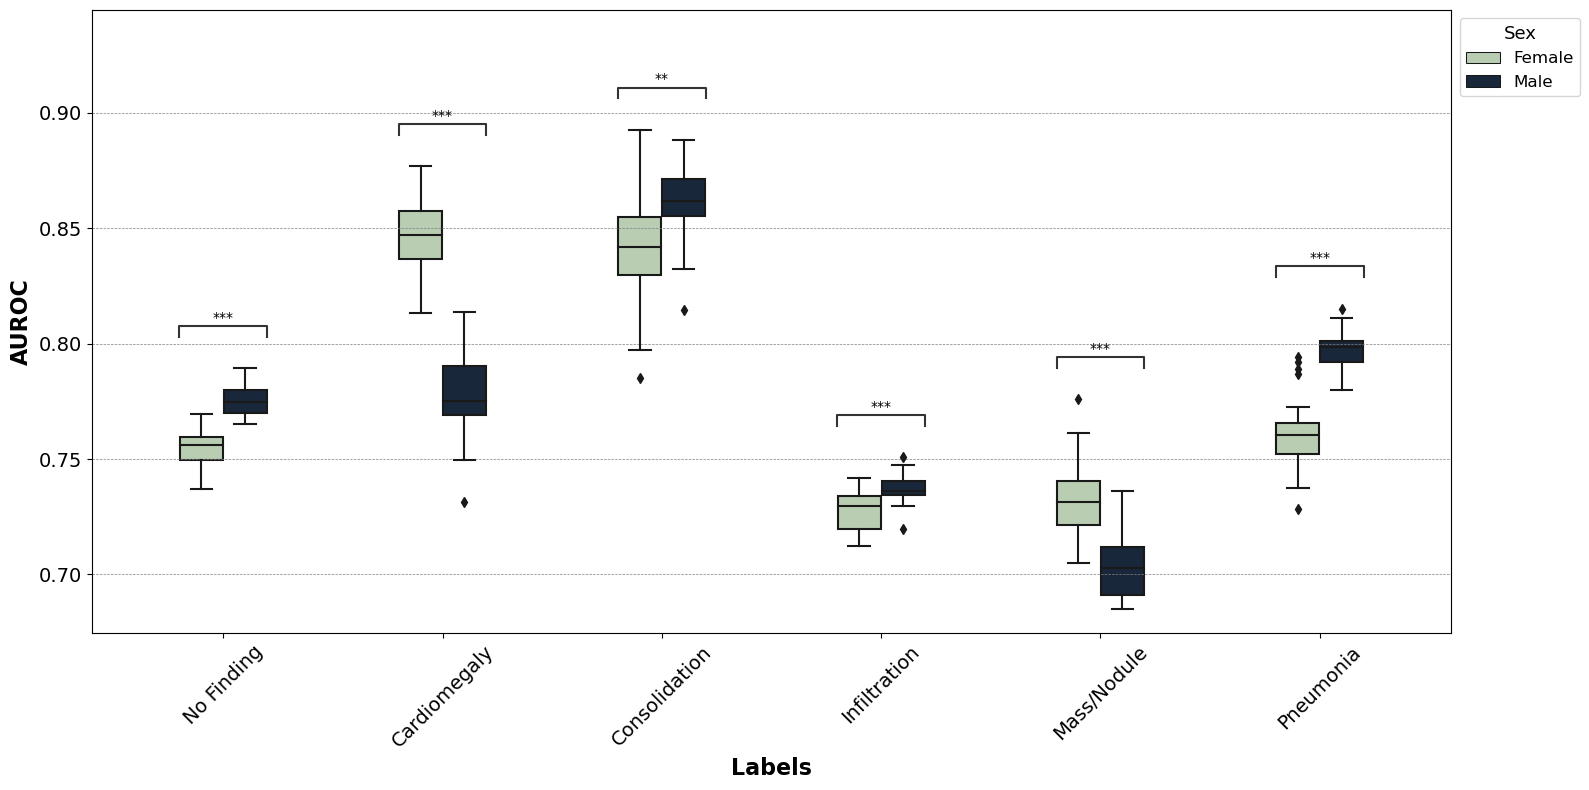

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

Cardiomegaly_Female v.s. Cardiomegaly_Male: Custom statistical test, P_val:1.936e-09
No Finding_Female v.s. No Finding_Male: Custom statistical test, P_val:8.077e-04
Consolidation_Female v.s. Consolidation_Male: Custom statistical test, P_val:2.407e-04
Infiltration_Female v.s. Infiltration_Male: Custom statistical test, P_val:4.255e-11
Mass/Nodule_Female v.s. Mass/Nodule_Male: Custom statistical test, P_val:1.969e-02
Pneumonia_Female v.s. Pneumonia_Male: Custom statistical test, P_val:2.540e-08


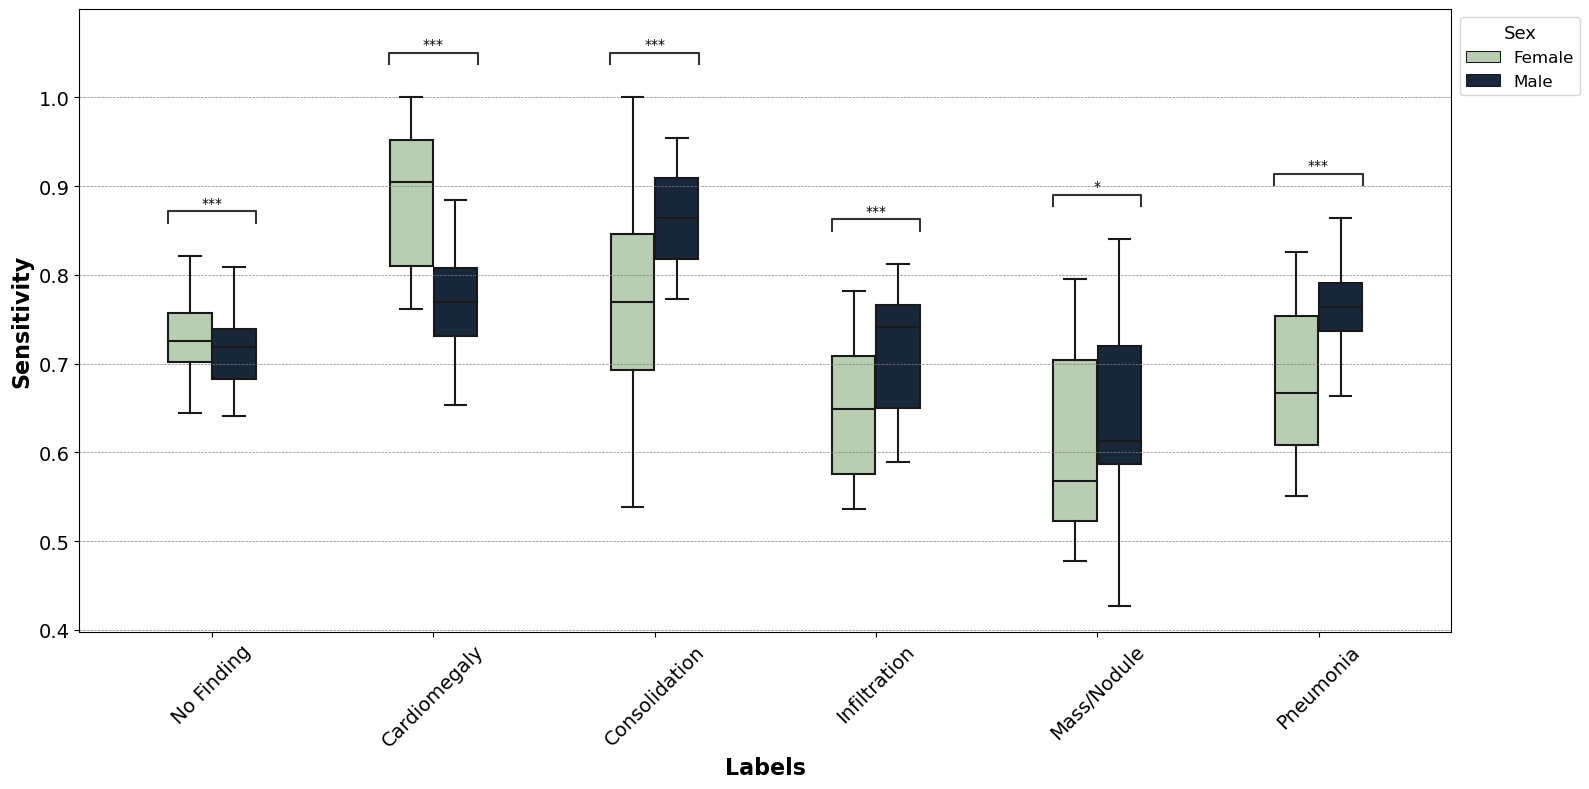

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

Cardiomegaly_Female v.s. Cardiomegaly_Male: Custom statistical test, P_val:8.605e-08
No Finding_Female v.s. No Finding_Male: Custom statistical test, P_val:4.361e-10
Consolidation_Female v.s. Consolidation_Male: Custom statistical test, P_val:1.208e-06
Infiltration_Female v.s. Infiltration_Male: Custom statistical test, P_val:4.361e-10
Mass/Nodule_Female v.s. Mass/Nodule_Male: Custom statistical test, P_val:4.361e-10
Pneumonia_Female v.s. Pneumonia_Male: Custom statistical test, P_val:3.413e-06


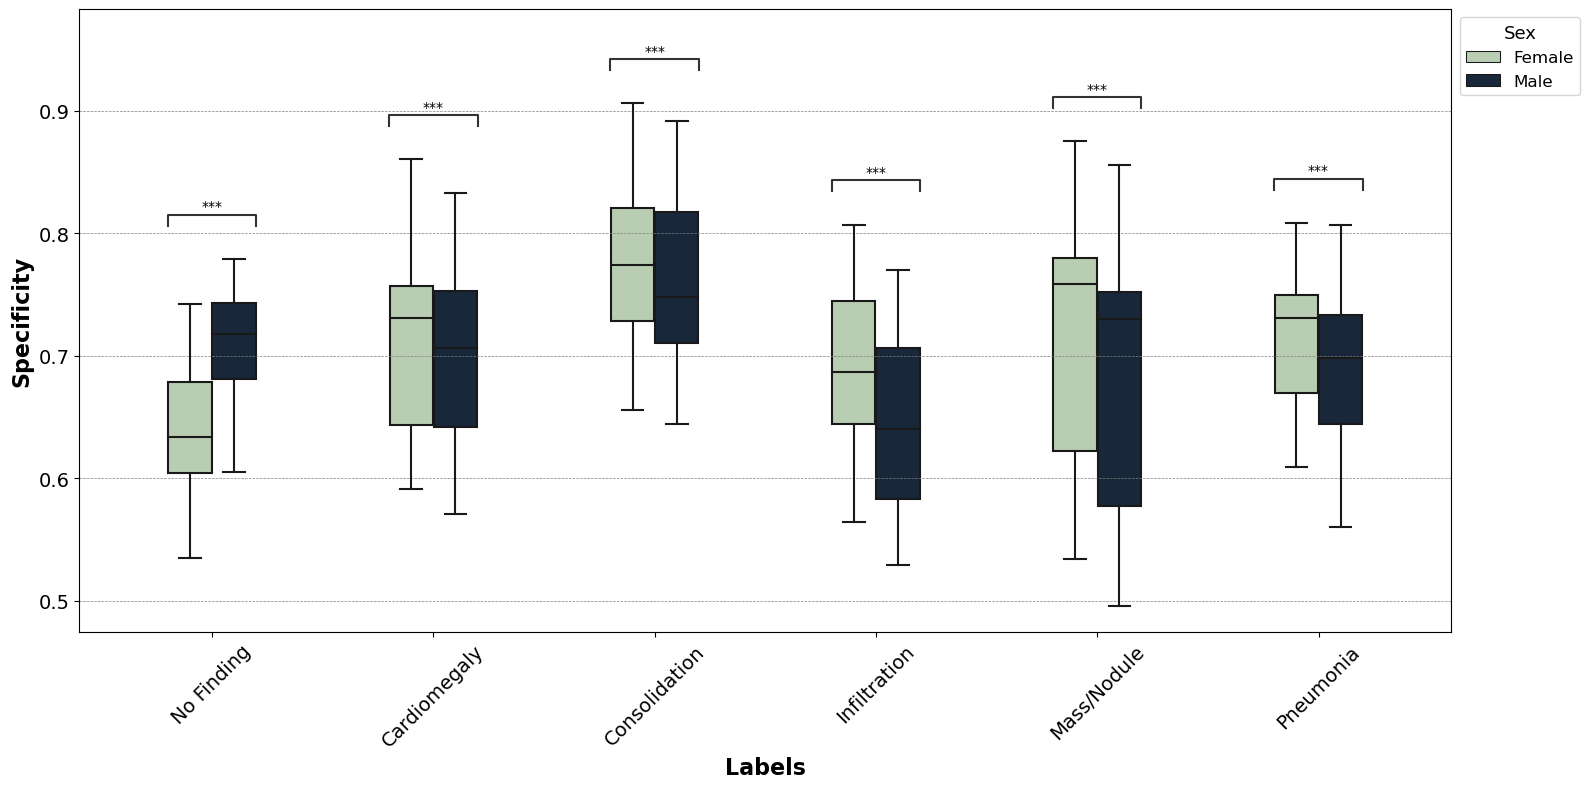

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

Cardiomegaly_Female v.s. Cardiomegaly_Male: Custom statistical test, P_val:3.674e-11
No Finding_Female v.s. No Finding_Male: Custom statistical test, P_val:1.935e-05
Consolidation_Female v.s. Consolidation_Male: Custom statistical test, P_val:6.493e-09
Infiltration_Female v.s. Infiltration_Male: Custom statistical test, P_val:4.169e-01
Mass/Nodule_Female v.s. Mass/Nodule_Male: Custom statistical test, P_val:7.706e-10
Pneumonia_Female v.s. Pneumonia_Male: Custom statistical test, P_val:5.248e-11


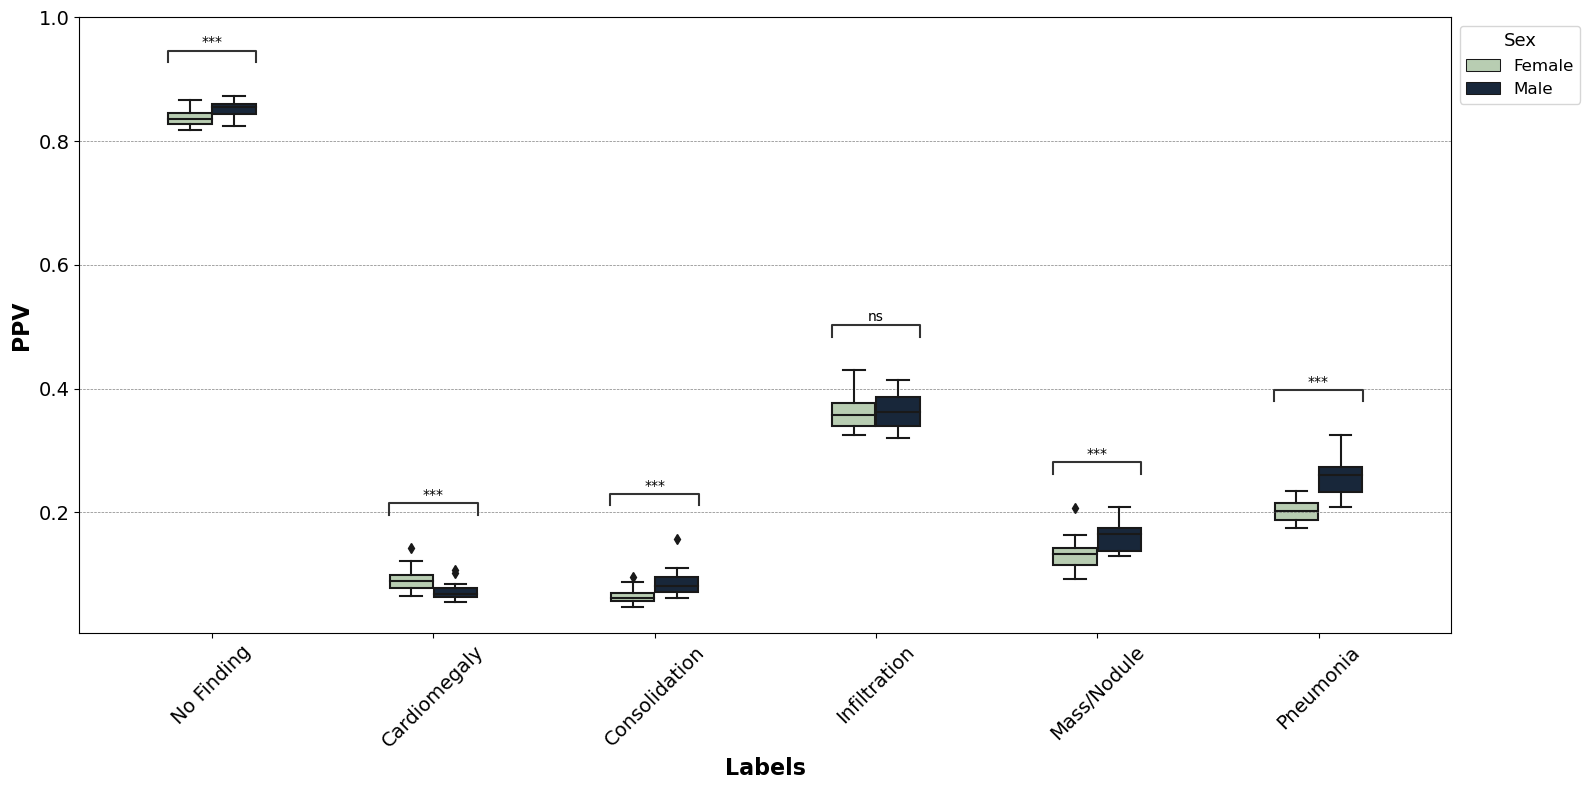

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

Cardiomegaly_Female v.s. Cardiomegaly_Male: Custom statistical test, P_val:1.936e-09
No Finding_Female v.s. No Finding_Male: Custom statistical test, P_val:3.135e-09
Consolidation_Female v.s. Consolidation_Male: Custom statistical test, P_val:6.936e-02
Infiltration_Female v.s. Infiltration_Male: Custom statistical test, P_val:2.529e-08
Mass/Nodule_Female v.s. Mass/Nodule_Male: Custom statistical test, P_val:9.426e-08
Pneumonia_Female v.s. Pneumonia_Male: Custom statistical test, P_val:2.360e-01


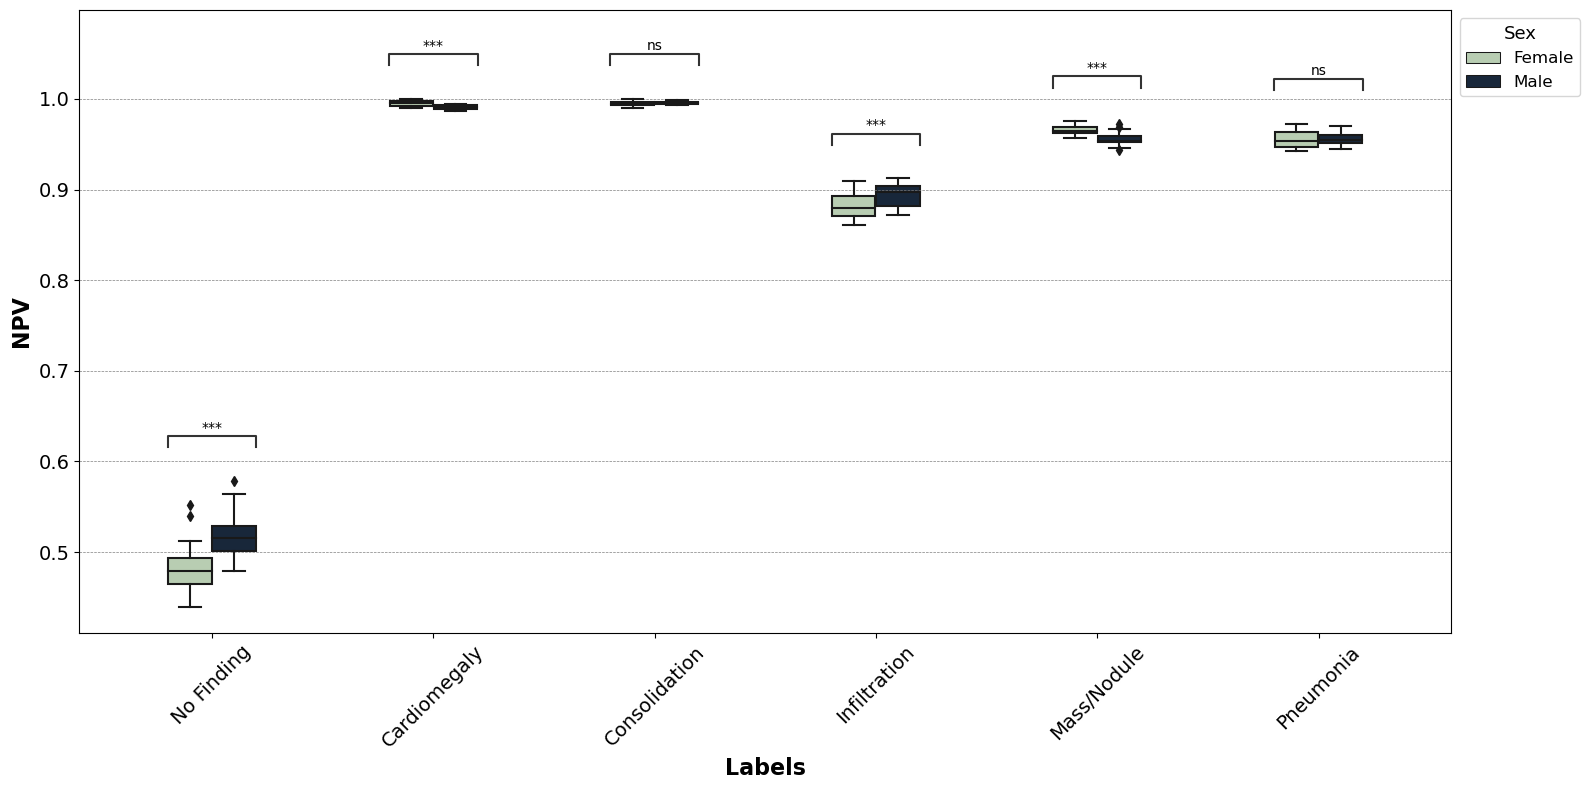

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

Cardiomegaly_Female v.s. Cardiomegaly_Male: Custom statistical test, P_val:2.734e-11
No Finding_Female v.s. No Finding_Male: Custom statistical test, P_val:5.102e-01
Consolidation_Female v.s. Consolidation_Male: Custom statistical test, P_val:3.975e-09
Infiltration_Female v.s. Infiltration_Male: Custom statistical test, P_val:8.292e-06
Mass/Nodule_Female v.s. Mass/Nodule_Male: Custom statistical test, P_val:1.272e-08
Pneumonia_Female v.s. Pneumonia_Male: Custom statistical test, P_val:3.674e-11


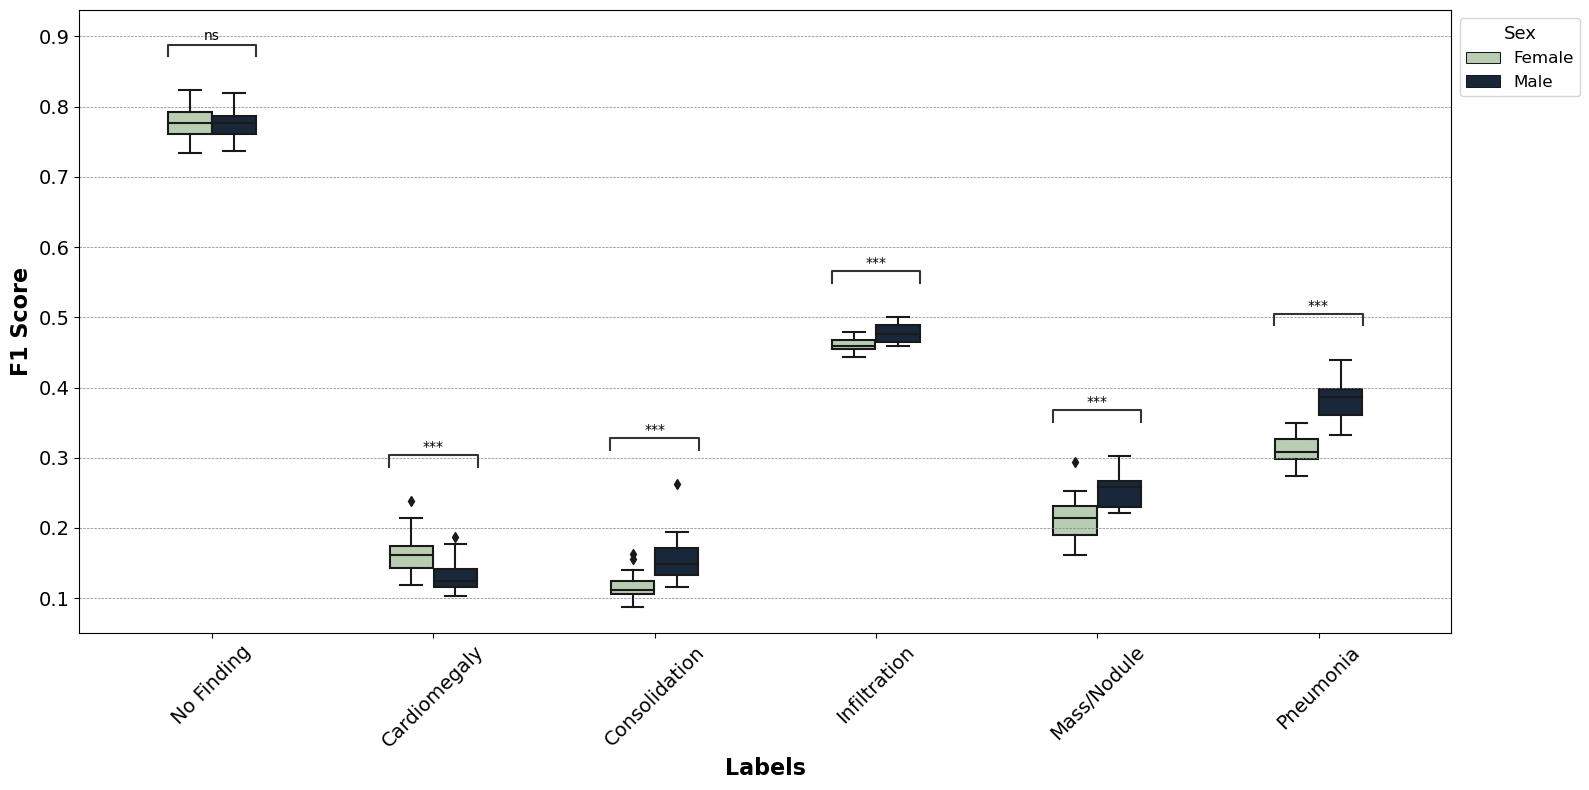

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

Cardiomegaly_Female v.s. Cardiomegaly_Male: Custom statistical test, P_val:8.605e-08
No Finding_Female v.s. No Finding_Male: Custom statistical test, P_val:4.361e-10
Consolidation_Female v.s. Consolidation_Male: Custom statistical test, P_val:1.208e-06
Infiltration_Female v.s. Infiltration_Male: Custom statistical test, P_val:4.361e-10
Mass/Nodule_Female v.s. Mass/Nodule_Male: Custom statistical test, P_val:4.361e-10
Pneumonia_Female v.s. Pneumonia_Male: Custom statistical test, P_val:3.413e-06


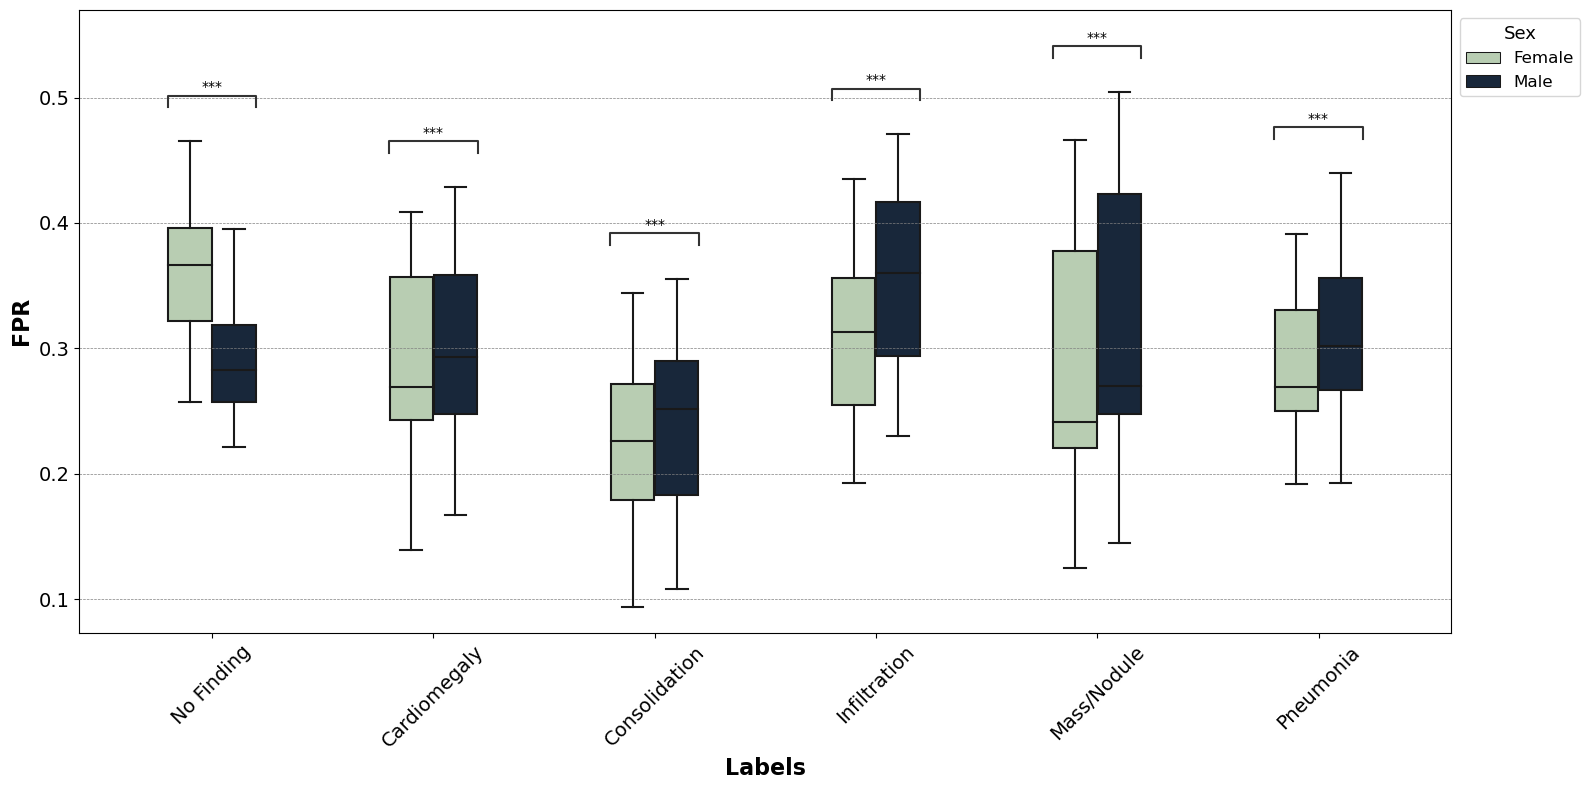

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

Cardiomegaly_Female v.s. Cardiomegaly_Male: Custom statistical test, P_val:1.936e-09
No Finding_Female v.s. No Finding_Male: Custom statistical test, P_val:8.077e-04
Consolidation_Female v.s. Consolidation_Male: Custom statistical test, P_val:2.407e-04
Infiltration_Female v.s. Infiltration_Male: Custom statistical test, P_val:4.255e-11
Mass/Nodule_Female v.s. Mass/Nodule_Male: Custom statistical test, P_val:1.969e-02
Pneumonia_Female v.s. Pneumonia_Male: Custom statistical test, P_val:2.540e-08


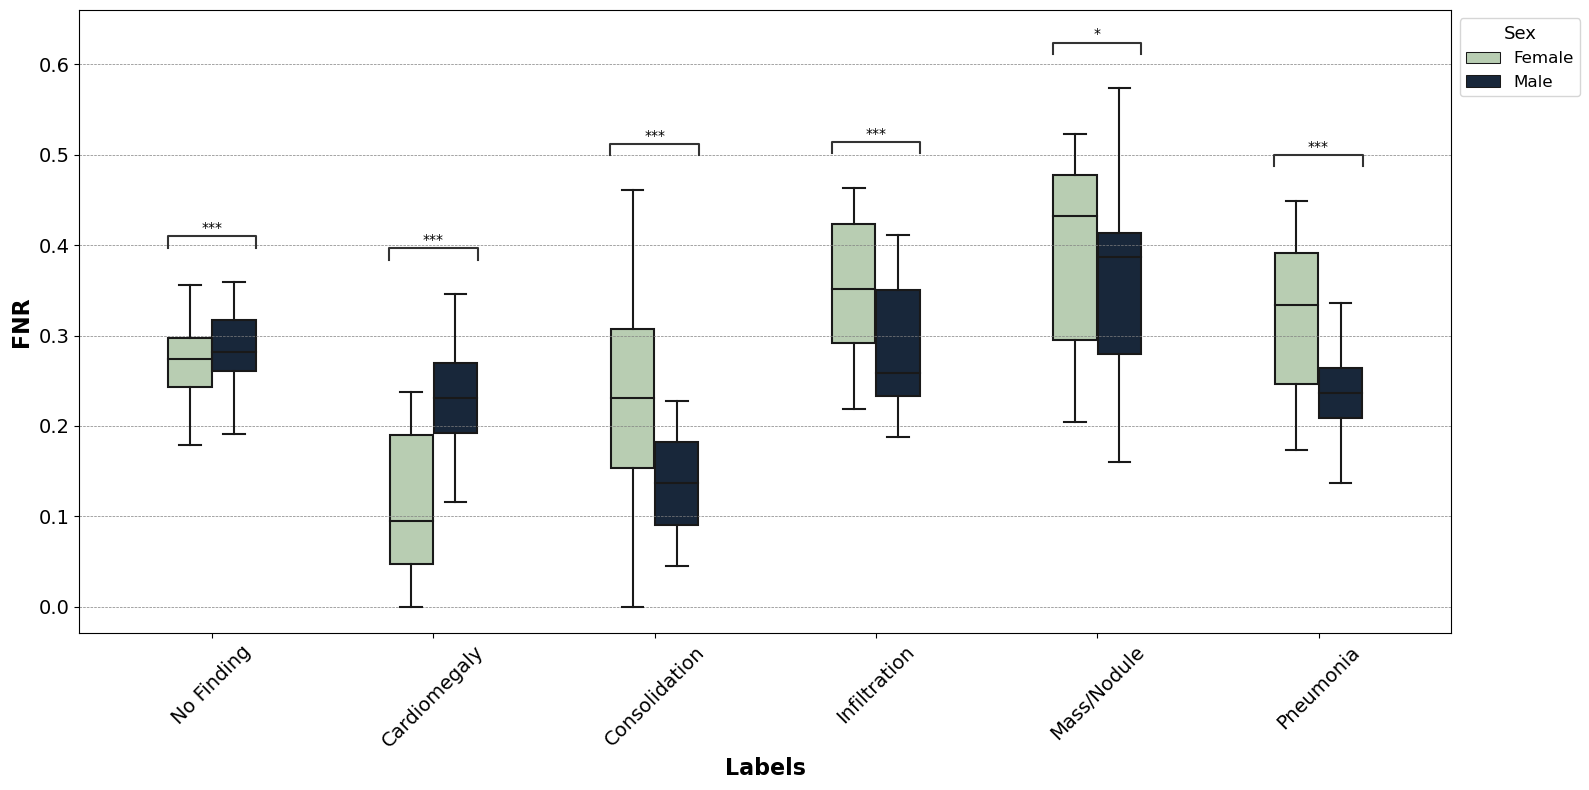

In [2]:
#Plotting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation

parent = '/home/jkim/research/peds_cxr/'
# Define paths and read the CSV files
vindr_MF_stats = pd.read_csv(parent + "25variation/results/vindr/analysis/csv/vindr_MF_stats.csv")
metrics_F_all = pd.read_csv(parent + "25variation/results/vindr/analysis/csv/metrics_F_all.csv")
metrics_M_all = pd.read_csv(parent + "25variation/results/vindr/analysis/csv/metrics_M_all.csv")

# Add sex column to metrics dataframes and combine them
metrics_F_all['Sex'] = 'Female'
metrics_M_all['Sex'] = 'Male'
combined_metrics = pd.concat([metrics_F_all, metrics_M_all])

# Extract unique metrics and labels
unique_metrics = vindr_MF_stats['Metric'].unique()
unique_labels = ["No Finding", "Cardiomegaly", "Consolidation", "Infiltration", "Mass/Nodule", "Pneumonia"]
neutral_palette = ["#b5d1ae", "#122740"]

for metric in unique_metrics:
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.boxplot(x='Label', y=metric, hue='Sex', data=combined_metrics, ax=ax, order=unique_labels, palette=neutral_palette, width=0.4)
    
    # Other plot adjustments
    ax.set_xlabel('Labels', fontsize=16, fontweight='bold')
    ax.set_ylabel(metric, fontsize=16, fontweight='bold')
    ax.tick_params(axis='x', labelsize=14, rotation=45)
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(True, linestyle='--', linewidth=0.5, color='gray', axis='y')

    # Prepare a list of tuples for box_pairs
    box_pairs = [((label, 'Female'),(label, 'Male')) for label in unique_labels]
    
    # Extract p-values for each label and metric combination
    p_values = [vindr_MF_stats[(vindr_MF_stats['Metric'] == metric) & 
                                    (vindr_MF_stats['Label'] == label)]['p_value_after_BH'].values[0] 
                for label in unique_labels]
    
    # Add statistical annotation
    add_stat_annotation(ax, data=combined_metrics, x='Label', y=metric, hue='Sex',
                        box_pairs=box_pairs, perform_stat_test=False, pvalues=p_values, 
                        test_short_name='Custom', loc='inside', verbose=2, 
                        pvalue_thresholds=[(0.001, '***'), (0.01, '**'), (0.05, '*'), (1, 'ns')])
    
    ax.legend(title='Sex', title_fontsize='13', fontsize='12', loc='upper left', bbox_to_anchor=(1, 1))

    
    # Save the plot
    plt.tight_layout()
    plot_file_path = parent + f'25variation/results/vindr/analysis/plot/MF/{metric}_comparison.jpeg'
    plt.savefig(plot_file_path, format='jpeg')
    plt.show()
    plt.close(fig)
